In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Sequential, Linear, ReLU, Softmax
from torch.nn import functional as F
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng

from gmm import GMM
# circuit-sim
# import subcircuit as sc
# import PySpice.Logging.Logging as Logging
# logger = Logging.setup_logging()
# from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
# from PySpice.Unit import *
# from PySpice.Spice.NgSpice.Shared import NgSpiceShared
# mps_device = torch.device("mps")
mps_device = torch.device("cpu")

| Type | Value                          | Type | Value                              |
|------|--------------------------------|------|------------------------------------|
| Node | capacitance value              | Path | input transition time              |
|      | num of input nodes             |      | drive strength of drive cell       |
|      | total input cap                |      | functionality  of drive cell       |
|      | total output cap               |      | drive strength of load cell        |
|      | number of connected resistance |      | functionality of load cell         |
|      | total input resistance         |      | effective capacitance of load cell |
|      | total output resistance        |      | wire path Elmore delay             |
|      | ~~Elmore downstream capacitance~~  |      | wire path D2M delay                |
|      | ~~Elmore stage delay~~             |      |                                    |

In [2]:
# import networkx as nx
# import random

# ''' Sample Graph '''
# # graph configuration
# num_nodes = 4
# num_edges = 3
# num_path_features = 8
# num_node_features = 9

# # set seed for random number generator
# random.seed(42)

# # create a linear graph with 4 nodes and 3 edges
# G = nx.path_graph(4)

# # assign random values to node attributes
# for i in range(num_nodes):
#     G.nodes[i]['capacitance'] = random.randint(1, 5)
#     if i == 0:
#         G.nodes[i]['num_input_nodes'] = 0
#     else:
#         G.nodes[i]['num_input_nodes'] = 1

#     G.nodes[i]['input_cap'] = 1
#     G.nodes[i]['output_cap'] = 1

#     if i == num_nodes - 1:
#         G.nodes[i]['connected_resistance'] = 0
#     else:
#         G.nodes[i]['connected_resistance'] = 1

#     G.nodes[i]['input_resistance'] = 1
#     G.nodes[i]['output_resistance'] = 1
#     G.nodes[i]['elmore_cap'] = 1

#     if i == 0:
#         G.nodes[i]['elmore_delay'] = 0
#     else:
#         G.nodes[i]['elmore_delay'] = 1


# # get the adjacency matrix
# M_adj = nx.adjacency_matrix(G)
# print("Adj Matrix: ", M_adj.A)

# # extract all paths
# paths = nx.all_simple_paths(G, source=0, target=3)
# list_of_paths = list(paths)
# print("Paths: ", list_of_paths)

# # create a matrix of [num_paths, num_path_features]
# M_path = torch.zeros(len(list_of_paths), num_path_features)

# # assign random value to the paths
# for i in range(len(list_of_paths)):
#     for j in range(num_path_features):
#         M_path[i,j] = random.randint(1, 5)

# print("Path Features: ", M_path)

# # assign random value to the edges
# for i in range(num_nodes):
#     for j in range(num_nodes):
#         if M_adj.A[i,j] == 1:
#             G.edges[i,j]['weight'] = random.randint(1, 5)

# # add edge weights to adjacency matrix
# for i in range(num_nodes):
#     for j in range(num_nodes):
#         if M_adj.A[i,j] == 1:
#             M_adj.A[i,j] = G.edges[i,j]['weight']

# print("Adj Matrix with Edge Weights: ", nx.adjacency_matrix(G).A)

# print("Resistance: ", G.edges.data('weight'))

# # plot the graph with edge weights
# nx.draw(G, with_labels=True, font_weight='bold')



$$x_i^{l_1} = ReLU(W_1^{l_1}x_i^{l_1-1}+W_2^{l_1}a_{iu}\sum_{u\in \mathcal{N}(v_i)}x_u^{l_1-1})$$

In [3]:
from torch_geometric.utils import to_dense_adj
# torch random seed
torch.manual_seed(42)

class L1_GNNModule(nn.Module):
    """
    Modified GraphSAGE module with weighted aggregation
    """
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.W1 = nn.Parameter(torch.randn(num_input_features, num_output_features) * 0.01).to(mps_device)
        self.W2 = nn.Parameter(torch.randn(num_input_features, num_output_features) * 0.01).to(mps_device)

    def forward(self, x, edge_index, edge_weight):
        neighbors_agg = to_dense_adj(edge_index, edge_attr=edge_weight).squeeze(0).to(mps_device)
        neighbors_agg = torch.matmul(neighbors_agg.float(), x.float())
        # linear transformation
        out = torch.matmul(neighbors_agg.to(torch.float32), self.W2.to(torch.float32)) + torch.matmul(x.to(torch.float32), self.W1.to(torch.float32))
        # relu activation
        out = torch.relu(out)
        return out

'''Test the GNN Module'''
# # input features from node attributes
# x = torch.tensor([[G.nodes[i]['capacitance'],
#                     G.nodes[i]['num_input_nodes'],
#                     G.nodes[i]['input_cap'],
#                     G.nodes[i]['output_cap'],
#                     G.nodes[i]['connected_resistance'],
#                     G.nodes[i]['input_resistance'],
#                     G.nodes[i]['output_resistance'],
#                     G.nodes[i]['elmore_cap'],
#                     G.nodes[i]['elmore_delay']] for i in range(num_nodes)], dtype=torch.float)

# print("Input Features: ", x)

# # extract edge index from adjacency matrix from networkx
# edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if M_adj.A[i,j] != 0], dtype=torch.long).t()

# # extract edge weights from networkx
# edge_weight = torch.tensor([G.edges[i,j]['weight'] for i in range(num_nodes) for j in range(num_nodes) if M_adj.A[i,j] != 0], dtype=torch.float)

# gnn = L1_GNNModule(num_node_features, num_node_features)
# out = gnn(x, edge_index, edge_weight)

# print("Output: ", out)
# print("Output Shape: ", out.shape)

'Test the GNN Module'

$$\tilde{a}_{iu}^{(k, l_2)} = softmax(\frac{W_Q^{(k, l_2)}x_i^{(L_1+l_2-1)}(W_k^{(k,l_2)}x_u^{(L_1+l_2-1)})}{\sqrt{d_k}})$$

$$x_i^{(L_1+l_2)} = x_i^{(L_1+l_2-1)} +  W_3^{(l_2)}||^{\mathcal{K}}_{k=1}\sum_{u\in \mathcal{V}}\tilde{a}_{iu}^{(k, l_2)}(W_V^{(k, l_2)}x_u^{(L_1+l_2-1)})$$


In [4]:
class L2_GNNModule(nn.Module):
    """Multi-head Attention GNN module
    """
    def __init__(self, num_input_features, num_output_features, num_of_heads=2):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn(num_of_heads, num_input_features, num_output_features) * 0.01).to(torch.float32).to(mps_device)
        self.Wk = nn.Parameter(torch.randn(num_of_heads, num_input_features, num_output_features) * 0.01).to(torch.float32).to(mps_device)
        self.Wv = nn.Parameter(torch.randn(num_of_heads, num_input_features, num_output_features) * 0.01).to(torch.float32).to(mps_device)
        self.W3 = nn.Parameter(torch.randn(num_input_features, num_output_features) * 0.01).to(torch.float32).to(mps_device)
        self.num_of_heads = num_of_heads
        self.num_output_features = num_output_features
        

    def forward(self, x, edge_index=None, edge_weight=None):
        # self-attention map A
        x = x.to(torch.float32)
        
        q = torch.matmul(x, self.Wq)
        q = q.view(-1, self.num_of_heads, self.num_output_features)
        k = torch.matmul(x, self.Wk)
        k = k.view(-1, self.num_of_heads, self.num_output_features)
        v = torch.matmul(x, self.Wv)
        v = v.view(-1, self.num_of_heads, self.num_output_features)

        # transpose to num_of_heads * num_nodes * num_node_features
        q = q.transpose(0,1)
        k = k.transpose(0,1)
        v = v.transpose(0,1)

        d_k = torch.tensor(self.num_output_features, dtype=torch.float)
        a_iu = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(d_k)
        a_iu = torch.softmax(a_iu, dim=-1)
        a_iu = torch.matmul(a_iu, v)

        # concat heads
        concat = a_iu.contiguous().view(self.num_of_heads, -1, self.num_output_features)
        
        # reshape to num_nodes * num_node_features by averaging over heads
        concat = concat.transpose(0,1)
        concat = concat.mean(dim=1)
        # use max instead of mean
        # concat = concat.max(dim=1)[0]

        l3 = torch.matmul(concat, self.W3)
        
        x = x + l3

        return x
        

'''Test the GNN Module'''
# # input features from node attributes
# x = torch.tensor([[G.nodes[i]['capacitance'],
#                     G.nodes[i]['num_input_nodes'],
#                     G.nodes[i]['input_cap'],
#                     G.nodes[i]['output_cap'],
#                     G.nodes[i]['connected_resistance'],
#                     G.nodes[i]['input_resistance'],
#                     G.nodes[i]['output_resistance'],
#                     G.nodes[i]['elmore_cap'],
#                     G.nodes[i]['elmore_delay']] for i in range(num_nodes)], dtype=torch.float)

# gnn = L2_GNNModule(num_node_features, num_node_features)
# out = gnn(x)

# print("Output: ", out)
# print("Output Shape: ", out.shape)

'Test the GNN Module'

In [5]:
class GNNtrans(nn.Module):
    def __init__(self, num_node, num_node_features, num_path_features) -> None:
        super().__init__()
        self.num_node = num_node
        self.num_node_features = num_node_features
        self.num_path_features = num_path_features
        self.gnn1 = L1_GNNModule(num_node, num_node_features)
        self.gnn2 = L1_GNNModule(num_node, num_node_features)
        self.gnn3 = L1_GNNModule(num_node, num_node_features)
        self.gnn4 = L1_GNNModule(num_node, num_node_features)
        self.gnn5 = L1_GNNModule(num_node, num_node_features)
        self.gnn6 = L1_GNNModule(num_node, num_node_features)
        self.gnn7 = L1_GNNModule(num_node, num_node_features)
        self.gnn8 = L1_GNNModule(num_node, num_node_features)
        self.gnn9 = L1_GNNModule(num_node, num_node_features)
        self.gnn10 = L1_GNNModule(num_node, num_node_features)
        self.trans1 = L2_GNNModule(num_node, num_node_features)
        self.trans2 = L2_GNNModule(num_node, num_node_features)
        self.trans3 = L2_GNNModule(num_node, num_node_features)
        self.trans4 = L2_GNNModule(num_node, num_node_features)
        self.trans5 = L2_GNNModule(num_node, num_node_features)
        # MLP layer predicting slew and delay
        self.linear_slew = nn.Linear(num_node_features + num_path_features, 1)
        self.linear_delay = nn.Linear(num_node_features + num_path_features + 1, 1)

    def forward(self, x, edge_index, edge_weight, path_indices, path_features):
        x = self.gnn1(x, edge_index, edge_weight)
        x = self.gnn2(x, edge_index, edge_weight)
        x = self.gnn3(x, edge_index, edge_weight)
        x = self.gnn4(x, edge_index, edge_weight)
        x = self.gnn5(x, edge_index, edge_weight)
        x = self.gnn6(x, edge_index, edge_weight)
        x = self.gnn7(x, edge_index, edge_weight)
        x = self.gnn8(x, edge_index, edge_weight)
        x = self.gnn9(x, edge_index, edge_weight)
        x = self.gnn10(x, edge_index, edge_weight)

        x = self.trans1(x, edge_index, edge_weight)
        x = self.trans2(x, edge_index, edge_weight)
        x = self.trans3(x, edge_index, edge_weight)
        x = self.trans4(x, edge_index, edge_weight)
        x = self.trans5(x, edge_index, edge_weight)

        # path aggregation
        y = torch.zeros(len(path_indices), self.num_path_features + self.num_node_features)
        # print("y: ", y.shape)

        for path_index, path_feature in zip(path_indices, path_features):
            # print("path_index: ", path_index)
            # select node based on path index
            x_path = torch.index_select(x, 0, path_index)
            # average pooling based on each path
            x_path = torch.mean(x_path, dim=0)
            # concatenate with path features
            x_path = torch.cat((x_path, path_feature))
            # add a dimension
            x_path = x_path.unsqueeze(0)
            # print("x_path: ", x_path.shape)
            
            # append to output
            torch.cat((y, x_path), dim=0)

        # predict slew
        slew = self.linear_slew(y)
        # concatenate slew with path features
        y = torch.cat((y, slew), dim=1)
        # predict delay
        delay = self.linear_delay(y)

        return slew, delay

In [6]:
# '''Test the GNN'''
# # input features from node attributes
# x = torch.tensor([[G.nodes[i]['capacitance'],
#                     G.nodes[i]['num_input_nodes'],
#                     G.nodes[i]['input_cap'],
#                     G.nodes[i]['output_cap'],
#                     G.nodes[i]['connected_resistance'],
#                     G.nodes[i]['input_resistance'],
#                     G.nodes[i]['output_resistance'],
#                     G.nodes[i]['elmore_cap'],
#                     G.nodes[i]['elmore_delay']] for i in range(num_nodes)], dtype=torch.float)

# # extract edge index from adjacency matrix from networkx
# edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if M_adj.A[i,j] != 0], dtype=torch.long).t()

# print(edge_index)

# # extract edge weights from networkx
# edge_weight = torch.tensor([G.edges[i,j]['weight'] for i in range(num_nodes) for j in range(num_nodes) if M_adj.A[i,j] != 0], dtype=torch.float)

# # extract path indices from networkx : node along the path
# all_path_indices = torch.tensor(list_of_paths, dtype=torch.long)

# # extract path features from networkx
# path_features = M_path
                                
# num_path_features = path_features.shape[1]

# gnn = GNNtrans(num_node_features, num_node_features, num_path_features)
# slew, delay = gnn(x, edge_index, edge_weight, all_path_indices, path_features)

# slew_target = 0.1
# slew_target = torch.tensor(slew_target, dtype=torch.float)
# delay_target = 0.2
# delay_target = torch.tensor(delay_target, dtype=torch.float)

# print("Slew: ", slew)
# print("Slew Shape: ", slew.shape)

# print("Delay: ", delay)
# print("Delay Shape: ", delay.shape)

# print("x Shape: ", x.shape)
# print("edge_index Shape: ", edge_index.shape)
# print("edge_weight Shape: ", edge_weight.shape)
# print("path_indices Shape: ", all_path_indices.shape)
# print("path_features Shape: ", path_features.shape)
# print("slew_target Shape: ", slew_target.shape)
# print("delay_target Shape: ", delay_target.shape)


## Pesudo-Training


In [7]:
# optimizer = torch.optim.Adam(gnn.parameters(), lr=0.01)

# for epoch in range(10):
#     optimizer.zero_grad()
#     slew, delay = gnn(x, edge_index, edge_weight, all_path_indices, path_features)
#     print("Slew: ", slew)
#     print("Delay: ", delay)
#     loss = F.mse_loss(slew, slew_target) + F.mse_loss(delay, delay_target)
#     loss.backward()
#     optimizer.step()
#     print("Epoch: ", epoch, " Loss: ", loss.item())

## Sample Extraction

In [8]:
import numpy as np 
import os

# extract sample from path
SAMPLE_DIR = "./sample/"

# extract sample from path
label_delay = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage8_label_delay.npy"))
label_delay = torch.from_numpy(label_delay)
label_delay = label_delay.to(torch.float32).to(mps_device)
label_slew = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage8_label_slew.npy"))
label_slew = torch.from_numpy(label_slew)
label_slew = label_slew.to(torch.float32).to(mps_device)
all_node_feature = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage8_node_features.npy"))
all_node_feature = torch.from_numpy(all_node_feature).to(torch.float32).to(mps_device)
all_path_feature = np.load(os.path.join(SAMPLE_DIR, "NumPath10000_NumStage8_path_features.npy"))
all_path_feature = np.expand_dims(all_path_feature, axis=1)
all_path_feature = torch.from_numpy(all_path_feature).to(torch.float32).to(mps_device)

print("label_delay Shape: ", label_delay.shape)
print("label_slew Shape: ", label_slew.shape)
print("node_feature Shape: ", all_node_feature.shape)
print("path_feature Shape: ", all_path_feature.shape)
    

label_delay Shape:  torch.Size([10000])
label_slew Shape:  torch.Size([10000])
node_feature Shape:  torch.Size([10000, 9, 9])
path_feature Shape:  torch.Size([10000, 1, 2])


In [9]:
print(all_node_feature[0][0])
print(all_node_feature[0][1])
print(all_node_feature[0][2])

num_samples = label_delay.shape[0]
num_node = all_node_feature.shape[1]
num_path = 1
num_node_features = all_node_feature.shape[2]
num_path_features = all_path_feature.shape[2]

# print
print("num_node: ", num_node)
print("num_path: ", num_path)
print("num_node_features: ", num_node_features)
print("num_path_features: ", num_path_features)

# build a adjacency matrix that all the nodes are connected to the previous and next node
M_adj = np.zeros((num_node, num_node))
for i in range(num_node):
    if i == 0:
        M_adj[i][i + 1] = all_node_feature[0][i][7]
    elif i == num_node - 1:
        M_adj[i][i - 1] = all_node_feature[0][i][6]
    else:
        M_adj[i][i - 1] = all_node_feature[0][i][6]
        M_adj[i][i + 1] = all_node_feature[0][i][7]

# print(M_adj)

# from adjacency matrix to edge index and edge weight
edge_index = torch.tensor(
    [[i, j] for i in range(num_node) for j in range(num_node) if M_adj[i, j] != 0],
    dtype=torch.long,
).t()
edge_weight = torch.tensor(
    [M_adj[i, j] for i in range(num_node) for j in range(num_node) if M_adj[i, j] != 0],
    dtype=torch.float,
)

print(edge_index.shape)
print(edge_weight.shape)

all_edge_index = []
all_edge_weight = []
# exit(0)

# now iterate through all the samples and stack them together
# edge_idx should be a 3D tensor of (10000, 2, 16)
# edge_weight should be a 2D tensor of (10000, 16)

for i in range(num_samples):
    M_adj = np.zeros((num_node, num_node))
    for j in range(num_node):
        if j == 0:
            M_adj[j][j + 1] = all_node_feature[i][j][7]
        elif j == num_node - 1:
            M_adj[j][j - 1] = all_node_feature[i][j][6]
        else:
            M_adj[j][j - 1] = all_node_feature[i][j][6]
            M_adj[j][j + 1] = all_node_feature[i][j][7]
    edge_index = torch.tensor(
        [[j, k] for j in range(num_node) for k in range(num_node) if M_adj[j, k] != 0],
        dtype=torch.long,
    ).t()
    edge_weight = torch.tensor(
        [
            M_adj[j, k]
            for j in range(num_node)
            for k in range(num_node)
            if M_adj[j, k] != 0
        ],
        dtype=torch.float,
    )
    all_edge_index.append(edge_index)
    all_edge_weight.append(edge_weight)

all_edge_index = torch.stack(all_edge_index).to(mps_device)
all_edge_weight = torch.stack(all_edge_weight).to(mps_device)

print(all_edge_index.shape)
print(all_edge_weight.shape)

tensor([ 0.,  0.,  1.,  0., 46.,  1.,  0., 47.,  0.])
tensor([ 7.,  1.,  2.,  7., 39.,  2.,  9., 38.,  1.])
tensor([ 8.,  1.,  2., 15., 31.,  2., 18., 29.,  2.])
num_node:  9
num_path:  1
num_node_features:  9
num_path_features:  2
torch.Size([2, 16])
torch.Size([16])
torch.Size([10000, 2, 16])
torch.Size([10000, 16])


In [10]:
# path_indices should be a 3D tensor of (10000, 1, 9) containing the indices of the nodes in the path
all_path_indices = np.zeros((num_samples, num_path, num_node))
for i in range(num_samples):
    all_path_indices[i][0] = np.arange(num_node)

print(all_path_indices.shape)
# to torch tensor with type int32
all_path_indices = torch.from_numpy(all_path_indices)
all_path_indices = all_path_indices.type(torch.int32).to(mps_device)

(10000, 1, 9)


# Trainning

In [11]:
GNN = GNNtrans(num_node, num_node_features, num_path_features)
GNN.to(mps_device)
optimizer = torch.optim.Adam(GNN.parameters(), lr=0.1)

loss_history = []

for epoch in range(100):
    epoch_loss = 0
    for sample_idx, (node_feature, edge_idx, edge_weight, path_idx, path_feature, slew_target, delay_target) in enumerate(
        zip(
            all_node_feature,
            all_edge_index,
            all_edge_weight,
            all_path_indices,
            all_path_feature,
            label_slew,
            label_delay,
        )
    ):
        optimizer.zero_grad()
        # print input shapes
        # print("node_feature Shape: ", node_feature.shape)
        # print("edge_idx Shape: ", edge_idx.shape)
        # print("edge_weight Shape: ", edge_weight.shape)
        # print("path_idx Shape: ", path_idx.shape)
        # print("path_feature Shape: ", path_feature.shape)
        # print("slew_target Shape: ", slew_target.shape)
        # print("delay_target Shape: ", delay_target.shape)
        slew, delay = GNN(node_feature, edge_idx, edge_weight, path_idx, path_feature)
        # print("predicted slew: ", slew)
        # print("predicted delay: ", delay)
        loss = F.mse_loss(slew, slew_target) + F.mse_loss(delay, delay_target)
        # print("predicted slew: {}, target slew: {}".format(slew, slew_target))
        # print("predicted delay: {}, target delay: {}".format(delay, delay_target))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss / num_samples)

    print("Epoch: ", epoch, " Avg Loss: ", epoch_loss / num_samples)

# save the model
torch.save(GNN.state_dict(), "GNNtrans.pt")

/var/folders/zy/r66k3sqd0rjgb7f3t3s92tqr0000gn/T/ipykernel_27689/2949141321.py:32: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(slew, slew_target) + F.mse_loss(delay, delay_target)


Epoch:  0  Avg Loss:  2267725.7723976565
Epoch:  1  Avg Loss:  809118.8778425743
Epoch:  2  Avg Loss:  349312.38388794253
Epoch:  3  Avg Loss:  304834.09741097386
Epoch:  4  Avg Loss:  302798.37735558284
Epoch:  5  Avg Loss:  302678.4872031021
Epoch:  6  Avg Loss:  302665.00002223055
Epoch:  7  Avg Loss:  302662.8593013771
Epoch:  8  Avg Loss:  302662.49430473556
Epoch:  9  Avg Loss:  302662.4198092445
Epoch:  10  Avg Loss:  302662.4072329163
Epoch:  11  Avg Loss:  302662.40449014056
Epoch:  12  Avg Loss:  302662.4021612236
Epoch:  13  Avg Loss:  302662.4008322304
Epoch:  14  Avg Loss:  302662.4011094978
Epoch:  15  Avg Loss:  302662.4024016266
Epoch:  16  Avg Loss:  302662.4048609749
Epoch:  17  Avg Loss:  302662.4076758743
Epoch:  18  Avg Loss:  302662.4088848282
Epoch:  19  Avg Loss:  302662.41024756164
Epoch:  20  Avg Loss:  302662.4111315979
Epoch:  21  Avg Loss:  302662.4110080864
Epoch:  22  Avg Loss:  302662.4082800613
Epoch:  23  Avg Loss:  302662.4098981918
Epoch:  24  Avg Lo

In [12]:
# reload the model
GNN = GNNtrans(num_node, num_node_features, num_path_features)
GNN.load_state_dict(torch.load("GNNtrans.pt"))

# test the model
test_idx = 0
test_node_feature = all_node_feature[test_idx]
test_edge_index = all_edge_index[test_idx]
test_edge_weight = all_edge_weight[test_idx]
test_path_idx = all_path_indices[test_idx]
test_path_feature = all_path_feature[test_idx]
test_slew_target = label_slew[test_idx]
test_delay_target = label_delay[test_idx]

test_slew, test_delay = GNN(
    test_node_feature,
    test_edge_index,
    test_edge_weight,
    test_path_idx,
    test_path_feature,
)

print("predicted slew: ", test_slew)
print("predicted delay: ", test_delay)
print("target slew: ", test_slew_target)
print("target delay: ", test_delay_target)

predicted slew:  tensor([[1646.6053]], grad_fn=<AddmmBackward0>)
predicted delay:  tensor([[645.2449]], grad_fn=<AddmmBackward0>)
target slew:  tensor(2293.3000)
target delay:  tensor(949.7000)


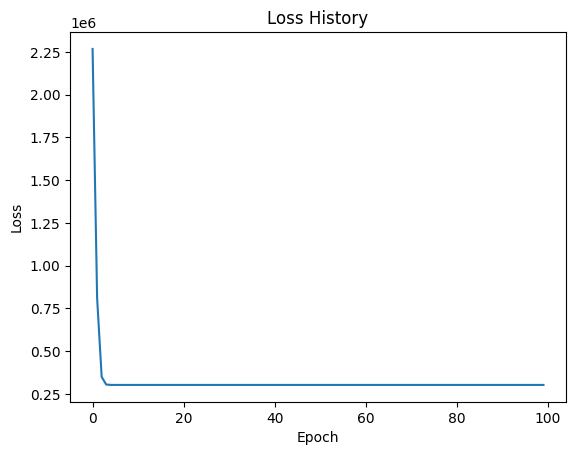

In [14]:
from matplotlib import pyplot as plt
# plot the loss history
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss History")
plt.show()

## Reference
- Base : https://colab.research.google.com/github/VisiumCH/AMLD-2021-Graphs/blob/master/notebooks/workshop_notebook.ipynb#scrollTo=7kPXvM8OxMJS
- GraphSAGE : https://colab.research.google.com/drive/1udeUfWJzvMlLO7sGUDGsHo8cRPMicajl?usp=sharing#scrollTo=wTR4wQG31Vtk
- GAT : https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/06-graph-neural-networks.ipynb#scrollTo=6c42fc29